In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:

train = pd.read_csv("train.csv")
test= pd.read_csv("test.csv")

In [ ]:
train.head()

,id,Date,Open,Close,Volume,Strategy
0,0,2015-06-01,66.208486,75.609978,298506300,Hold
1,1,2015-06-08,64.116235,74.443331,227974800,Hold
2,2,2015-06-15,47.701942,71.140831,250670900,Buy
3,3,2015-06-22,54.754816,72.881344,223614300,Hold
4,4,2015-06-29,48.031899,66.284718,406814900,Buy


# Your model creation, training and inferencing code, along with suitable analysis and reasoning

In [ ]:
# import all libraries

# import all libraries

import pandas as pd
import numpy as np


# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot

# For time stamps
from datetime import datetime

from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.
from statsmodels.tsa.seasonal import seasonal_decompose


from sklearn.model_selection import train_test_split

import statsmodels.graphics.tsaplots as sgt
from sklearn.preprocessing import StandardScaler
# ARIMA
from statsmodels.tsa.arima.model import ARIMA


from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# import ensemble models

from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,recall_score,precision_score,roc_auc_score


In [ ]:
data= train.copy()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        300 non-null    int64  
 1   Date      300 non-null    object 
 2   Open      300 non-null    float64
 3   Close     300 non-null    float64
 4   Volume    300 non-null    int64  
 5   Strategy  300 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 14.2+ KB


In [ ]:
data.describe()

,id,Open,Close,Volume
count,300.000000,300.000000,300.000000,3.000000e+02
mean,149.500000,75.977813,79.430489,1.866300e+08
std,86.746758,16.158343,13.878395,7.952792e+07
min,0.000000,40.269435,47.979353,5.991330e+07
25%,74.750000,64.872395,69.689227,1.324862e+08
50%,149.500000,79.805683,82.991900,1.715536e+08
75%,224.250000,88.342927,89.719145,2.201842e+08
max,299.000000,102.558322,103.119373,6.935702e+08


In [ ]:
data.shape

(300, 6)

# DATA PREPROCESSING

## Check for missing data points

In [ ]:
data.isnull().sum()

id          0
Date        0
Open        0
Close       0
Volume      0
Strategy    0
dtype: int64

No missing data points in train data

## Preprocess Data

- Hold - 1
- Buy - 0
- Sell - 2

In [ ]:
# classify Strategy as categorical variable
# label Strategy
data['Strategy'] = data['Strategy'].astype('category')
data['Strategy'] = data['Strategy'].map({"Hold":1,"Buy":0,"Sell":2})
data['Strategy'].value_counts()

# convert Date to datetime
data['Date'] = pd.to_datetime(data['Date'])

data.head()

,id,Date,Open,Close,Volume,Strategy
0,0,2015-06-01,66.208486,75.609978,298506300,1
1,1,2015-06-08,64.116235,74.443331,227974800,1
2,2,2015-06-15,47.701942,71.140831,250670900,0
3,3,2015-06-22,54.754816,72.881344,223614300,1
4,4,2015-06-29,48.031899,66.284718,406814900,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        300 non-null    int64         
 1   Date      300 non-null    datetime64[ns]
 2   Open      300 non-null    float64       
 3   Close     300 non-null    float64       
 4   Volume    300 non-null    int64         
 5   Strategy  300 non-null    category      
dtypes: category(1), datetime64[ns](1), float64(2), int64(2)
memory usage: 12.3 KB


## Check for Outliers

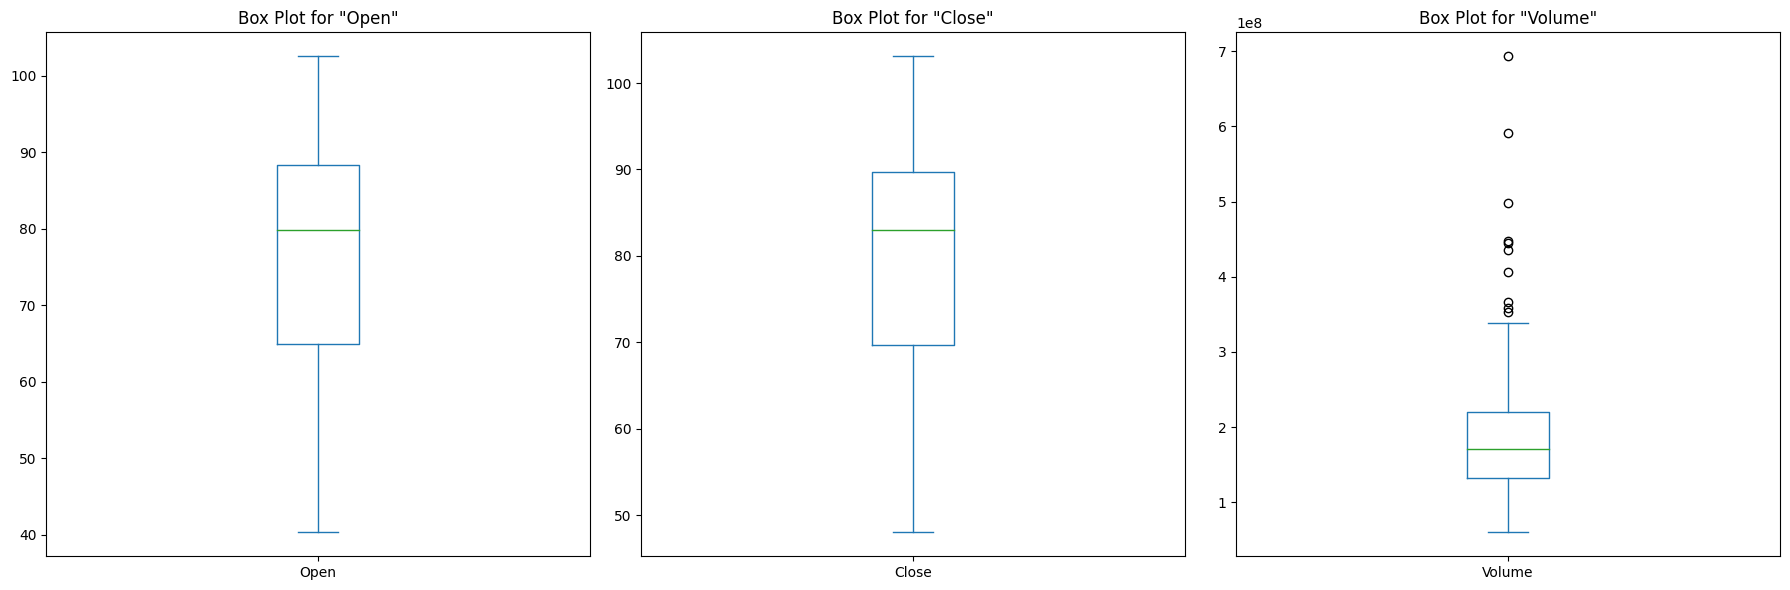

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
# Create box plots for 'Open,' 'Close,' and 'Volume' columns
data[['Open']].plot(kind='box', ax=axes[0])
data[['Close']].plot(kind='box', ax=axes[1])
data[['Volume']].plot(kind='box', ax=axes[2])

# Set titles for each subplot
axes[0].set_title('Box Plot for "Open"')
axes[1].set_title('Box Plot for "Close"')
axes[2].set_title('Box Plot for "Volume"')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()



As due to some reasons the volume of a stock may increase. So, we are avoiding to remove it.

### Building a Scatter plot for volume to check if outliers are accumulated at a particular year


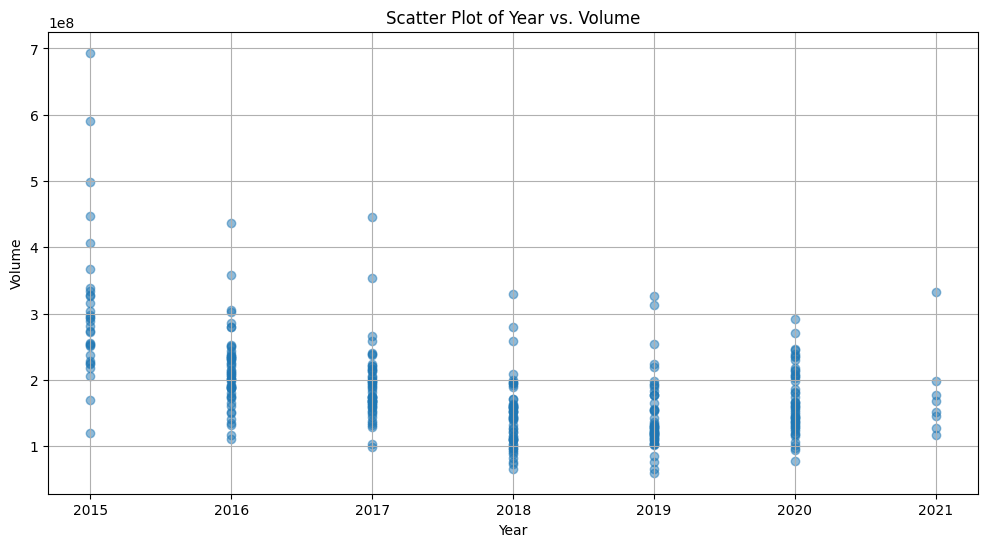

In [ ]:
# Convert the "Date" column to a datetime object
Date= pd.to_datetime(data['Date'])
# Extract the year from the "Date" column
Year=Date.dt.year

# Create a scatter plot of Year vs. Volume
plt.figure(figsize=(12, 6))
plt.scatter(Year, data['Volume'], alpha=0.5)
plt.title("Scatter Plot of Year vs. Volume")
plt.xlabel("Year")
plt.ylabel("Volume")
plt.grid(True)
plt.show()

# Data Visualization

<AxesSubplot:>

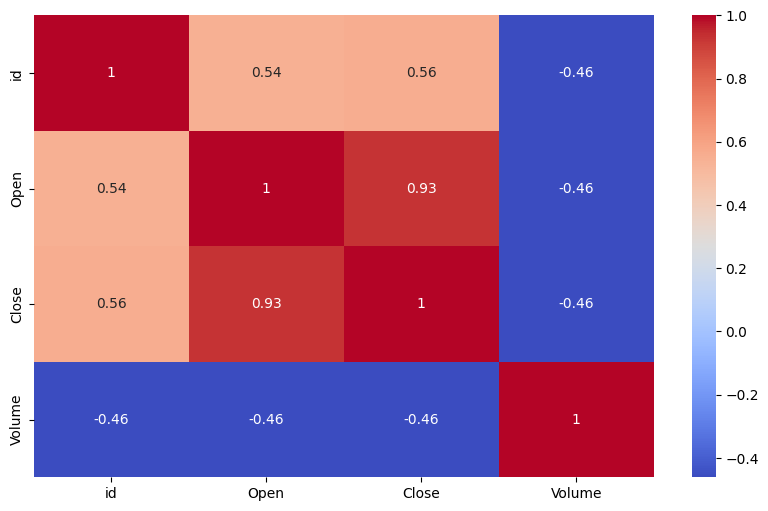

In [ ]:
corr = data.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')

None of the values are highly correlated among themselves except for Close. So we don't remove any features

<AxesSubplot:xlabel='Close', ylabel='Density'>

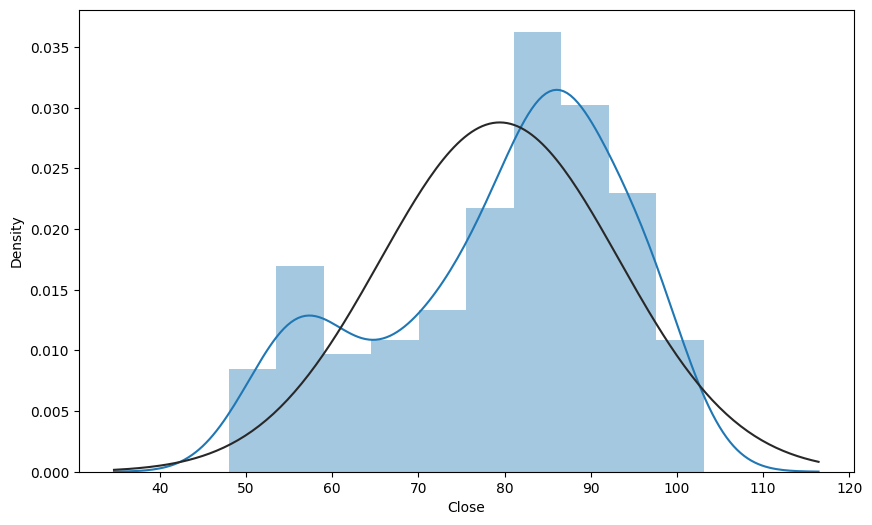

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(data['Close'], fit=norm)

<AxesSubplot:xlabel='Open', ylabel='Density'>

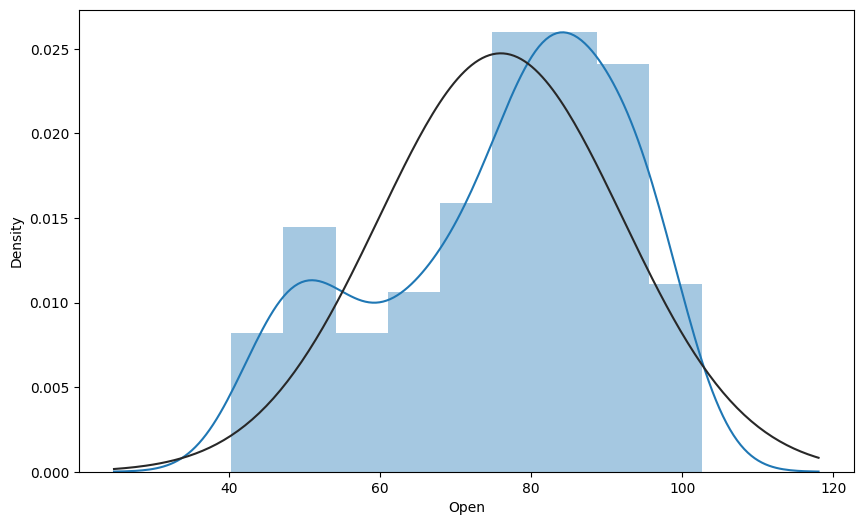

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(data['Open'], fit=norm)

<AxesSubplot:xlabel='Volume', ylabel='Density'>

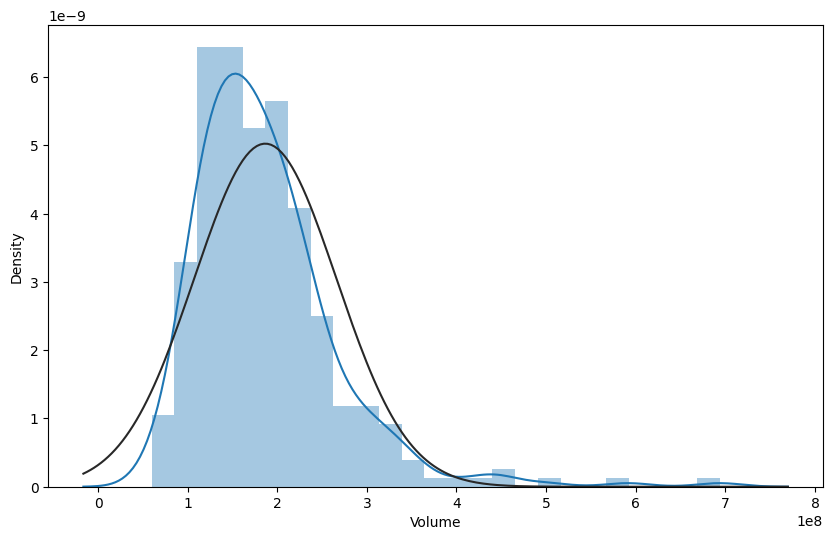

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(data['Volume'], fit=norm)

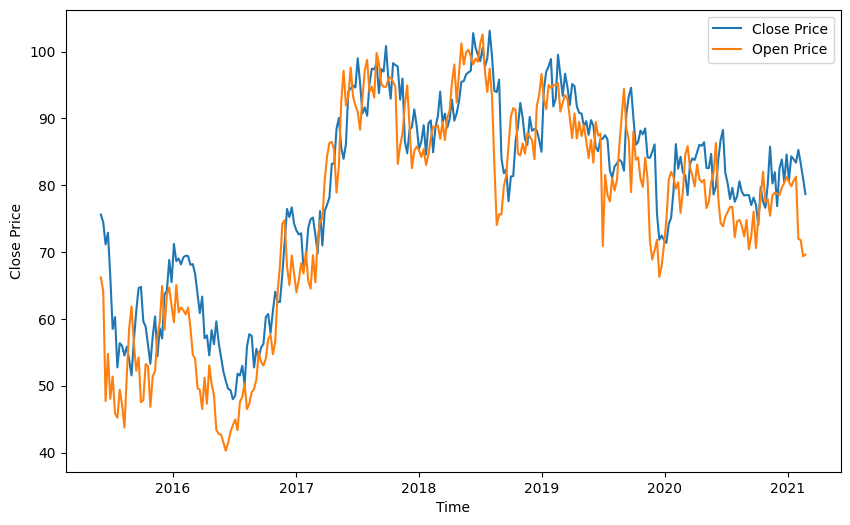

In [ ]:
# plot open vs close price over the years

plt.figure(figsize=(10, 6))

plt.plot(data['Date'], data['Close'], label='Close Price')
plt.plot(data['Date'], data['Open'], label='Open Price')

plt.xlabel('Time')

plt.ylabel('Close Price')

plt.legend()

plt.show()

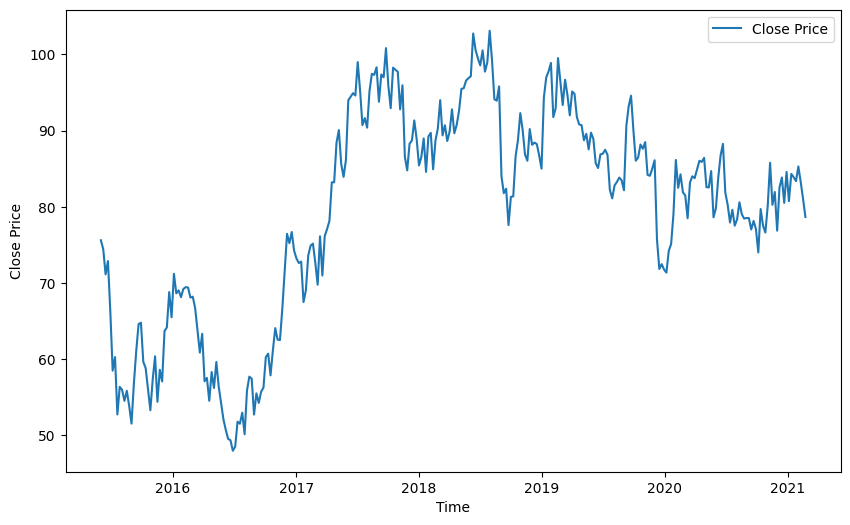

In [ ]:
# Plot close price over the years
plt.figure(figsize=(10, 6))

plt.plot(data['Date'], data['Close'], label='Close Price')
plt.xlabel('Time')

plt.ylabel('Close Price')
plt.legend()


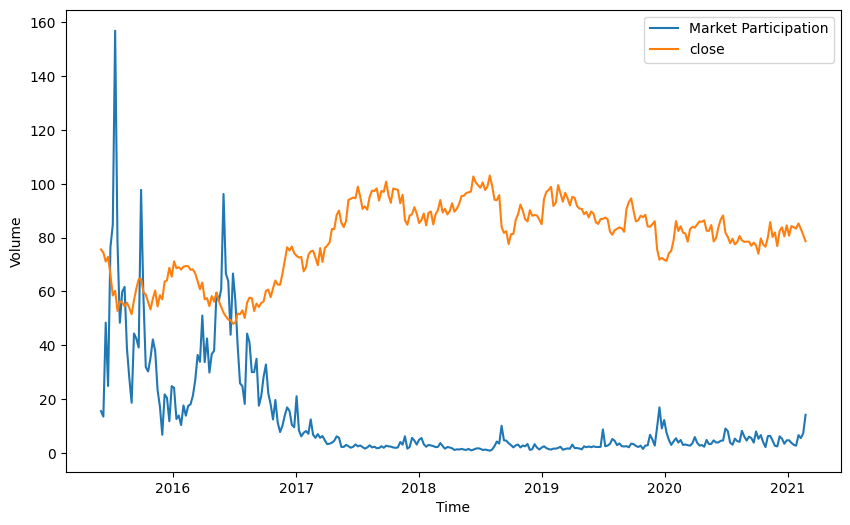

In [ ]:
# plot volume over the years

plt.figure(figsize=(10, 6))

plt.plot(data['Date'], data['Volume']/(data['Open'])**4, label='Market Participation')
plt.plot(data['Date'], data['Close'], label='close')


plt.xlabel('Time')

plt.ylabel('Volume')

plt.legend()

plt.show()

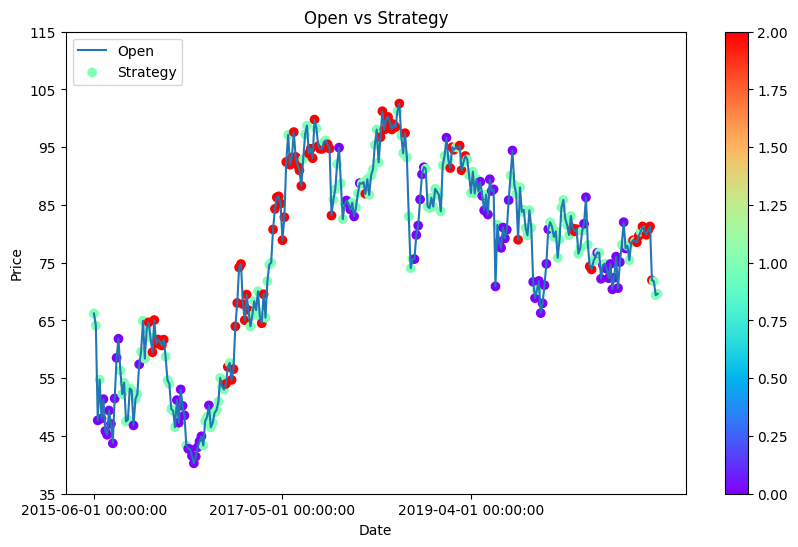

In [ ]:
# plot between open and strategy over the period of time

plt.figure(figsize=(10,6))
plt.plot(data['Open'])
# colour code curve for different strategy

plt.scatter(data.index, data['Open'], c=data['Strategy'], cmap='rainbow')
plt.colorbar()


plt.title('Open vs Strategy')
plt.ylabel('Price')
plt.xlabel('Date')

plt.legend(['Open','Strategy'], loc='upper left')
# set x axis to have date's year
plt.xticks(np.arange(0,300, 100), data['Date'][0:300:100])
plt.yticks(np.arange(35, 120, 10))

plt.show()


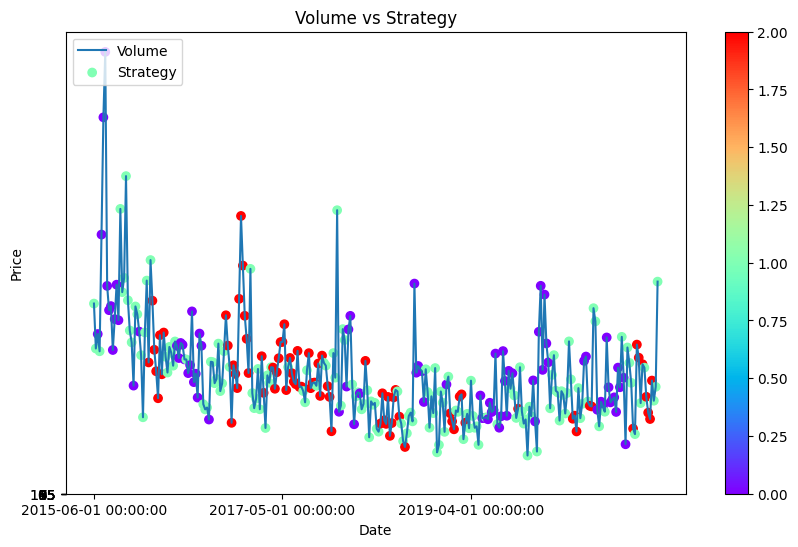

In [ ]:
# plot between Volume and strategy over the period of time

plt.figure(figsize=(10,6))
plt.plot(data['Volume'])
# colour code curve for different strategy

plt.scatter(data.index, data['Volume'], c=data['Strategy'], cmap='rainbow')
plt.colorbar()


plt.title('Volume vs Strategy')
plt.ylabel('Price')
plt.xlabel('Date')

plt.legend(['Volume','Strategy'], loc='upper left')
# set x axis to have date's year
plt.xticks(np.arange(0,300, 100), data['Date'][0:300:100])
plt.yticks(np.arange(35, 120, 10))

plt.show()


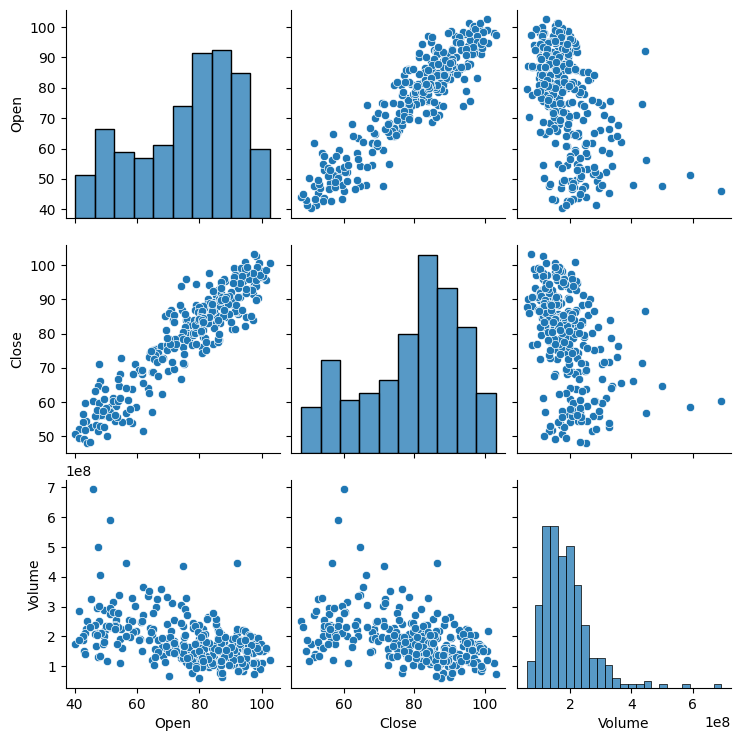

In [ ]:
sns.pairplot(data, vars=['Open','Close', 'Volume'])
plt.show()

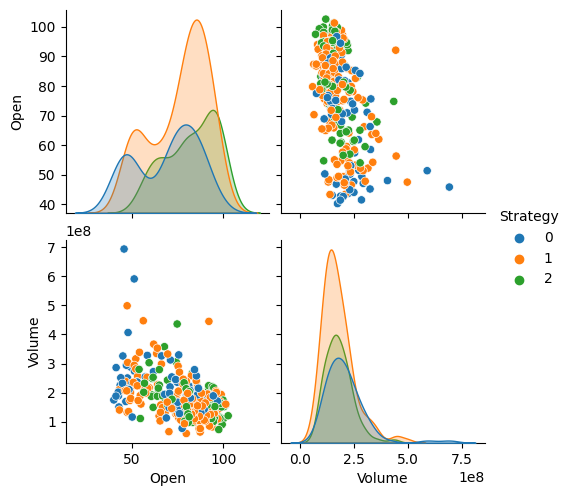

In [ ]:
sns.pairplot(data[["Open","Volume","Strategy","Date"]],hue="Strategy")

Auto- correlation plots

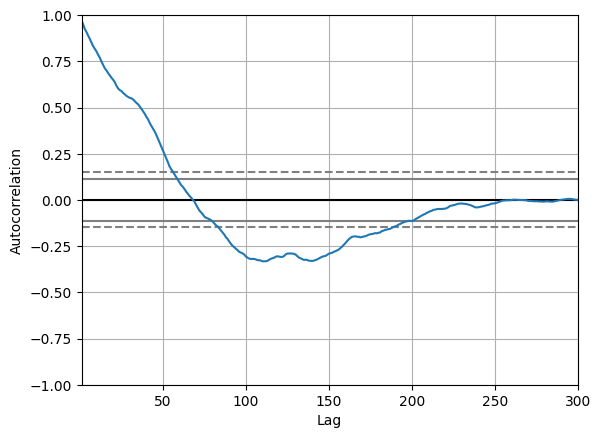

In [ ]:
autocorrelation_plot(data['Open'])
plt.show()

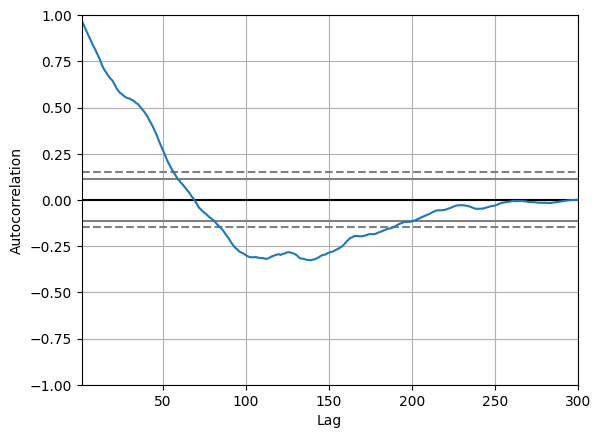

In [ ]:
autocorrelation_plot(data['Close'])
plt.show()

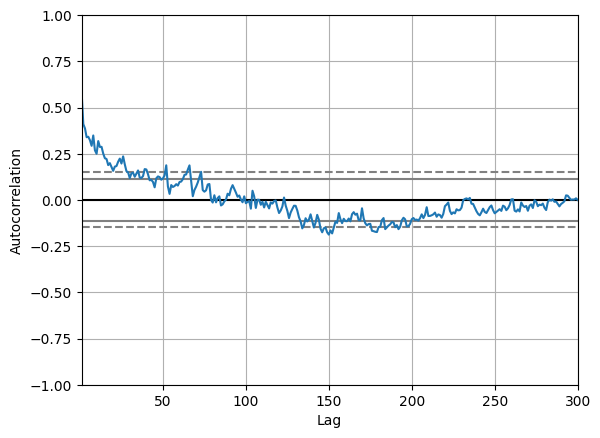

In [ ]:
autocorrelation_plot(data['Volume'])
plt.show()

Skew and Kurtosis

In [ ]:
skewness= data.skew()
kurtosis= data.kurtosis()


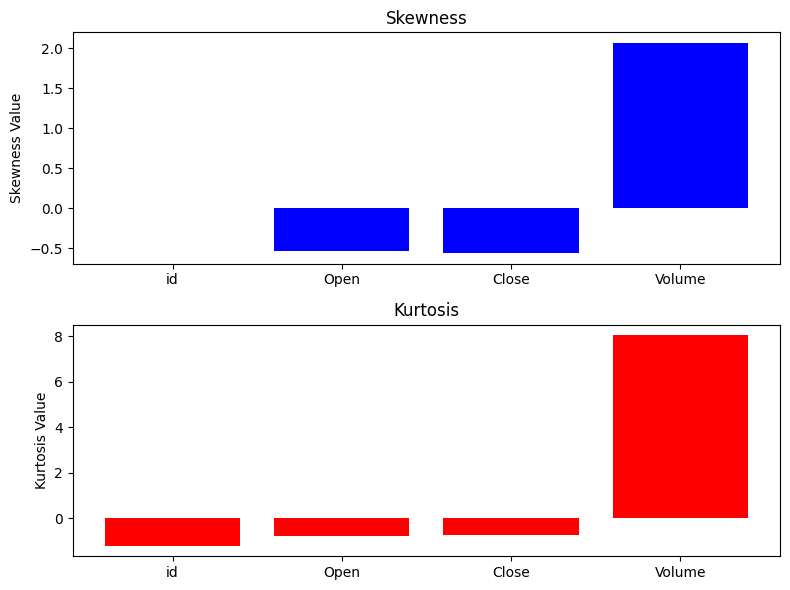

In [ ]:
# Create subplots for skewness and kurtosis
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# Plot Skewness
axes[0].bar(skewness.index, skewness.values, color='blue')
axes[0].set_title('Skewness')
axes[0].set_ylabel('Skewness Value')

# Plot Kurtosis
axes[1].bar(kurtosis.index, kurtosis.values, color='red')
axes[1].set_title('Kurtosis')
axes[1].set_ylabel('Kurtosis Value')

# Adjust subplot spacing
plt.tight_layout()

# Show the plot
plt.show()

## Linear Regression Analysis

In [ ]:
import statsmodels.api as sm

X = data[['Open', 'Volume']]
y = data['Close']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     927.8
Date:                Wed, 01 Nov 2023   Prob (F-statistic):          1.81e-128
Time:                        22:35:02   Log-Likelihood:                -917.17
No. Observations:                 300   AIC:                             1840.
Df Residuals:                     297   BIC:                             1851.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.3567      2.094     10.201      0.0

<AxesSubplot:xlabel='Open', ylabel='Close'>

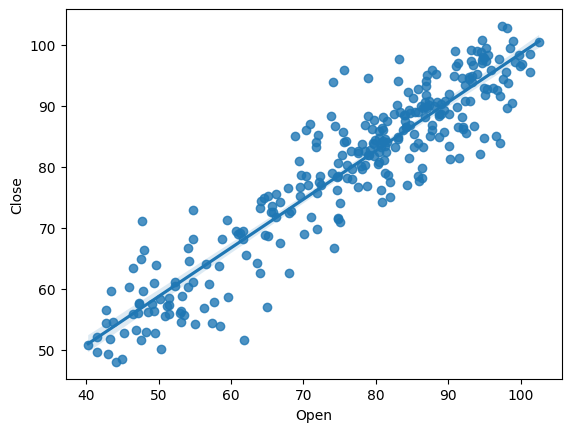

In [ ]:
# reg plot

sns.regplot(x='Open', y='Close', data=data)


<AxesSubplot:xlabel='Volume', ylabel='Close'>

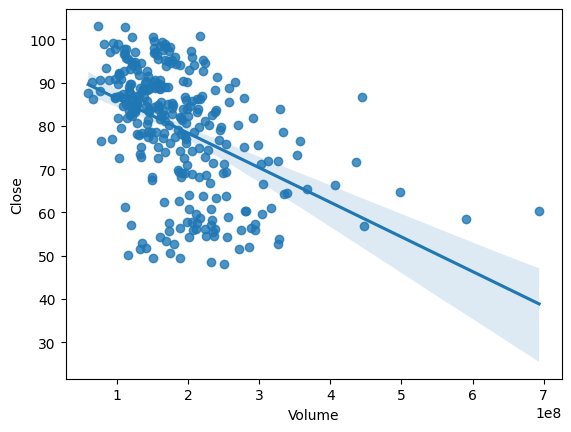

In [ ]:
sns.regplot(x='Volume', y='Close', data=data)


# ADFuller testing

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(data):
    result = adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','#Observation Used']
    for value,label in zip(result,labels):
        print(label  + ': ' + str(value))
    if result[1]<=0.05:
        print('Strong evidence against the null hypothesis, Hence REJECT Ho. and The series is Stationary')
    else:
        print('Weak evidence against null hypothesis, Hence ACCEPT Ho. that the series is not stationary.')


In [ ]:
adfuller_test(data['Open'])

ADF Test Statistic: -1.9042198166816637
p-value: 0.3300785872505526
#Lags Used: 1
#Observation Used: 298
Weak evidence against null hypothesis, Hence ACCEPT Ho. that the series is not stationary.


In [ ]:
adfuller_test(data['Close'])

ADF Test Statistic: -1.8080055426222839
p-value: 0.37649446979222034
#Lags Used: 1
#Observation Used: 298
Weak evidence against null hypothesis, Hence ACCEPT Ho. that the series is not stationary.


In [ ]:
adfuller_test(data['Volume'])


ADF Test Statistic: -3.327071678181229
p-value: 0.013710894607624643
#Lags Used: 10
#Observation Used: 289
Strong evidence against the null hypothesis, Hence REJECT Ho. and The series is Stationary


The dotted lines in the plot correspond to 95% and 99% confidence bands. If the autocorrelation crosses these bands, then it's statistically significant.

<Figure size 1000x1000 with 0 Axes>

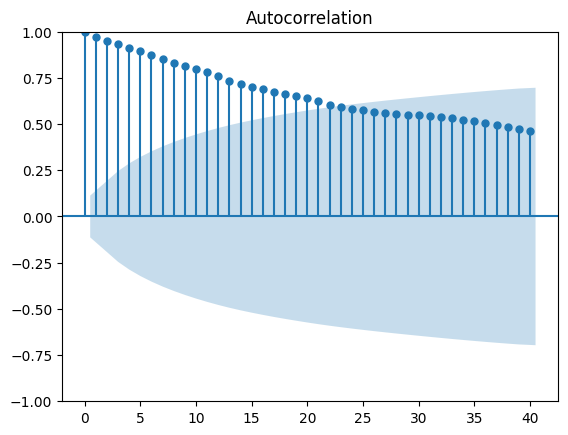

In [ ]:
# plot auto-correlation

plt.figure(figsize=(10, 10))

# Plot autocorrelation
plot_acf(data['Close'], lags=40)

plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf

val = data['Close'].values

# Calculate autocorrelation and confidence intervals
autocorr, confint = acf(val, nlags=40, alpha=0.05, fft=True)

# Print autocorrelations and confidence intervals
for i in range(len(autocorr)):
    print('Lag: %s' % i)
    print('Autocorrelation: %s' % autocorr[i])
    print('Confidence interval: %s' % confint[i])
    print('---')


Lag: 0
Autocorrelation: 1.0
Confidence interval: [1. 1.]
---
Lag: 1
Autocorrelation: 0.9722555260721024
Confidence interval: [0.85909695 1.0854141 ]
---
Lag: 2
Autocorrelation: 0.951689492165452
Confidence interval: [0.75930123 1.14407776]
---
Lag: 3
Autocorrelation: 0.931299609403843
Confidence interval: [0.68592581 1.17667341]
---
Lag: 4
Autocorrelation: 0.9120885315664539
Confidence interval: [0.62499951 1.19917755]
---
Lag: 5
Autocorrelation: 0.8929610790556907
Confidence interval: [0.57089746 1.2150247 ]
---
Lag: 6
Autocorrelation: 0.8739702468797316
Confidence interval: [0.52162717 1.22631333]
---
Lag: 7
Autocorrelation: 0.853114430543195
Confidence interval: [0.47402741 1.23220145]
---
Lag: 8
Autocorrelation: 0.8331014186557135
Confidence interval: [0.4301798  1.23602304]
---
Lag: 9
Autocorrelation: 0.816887812232364
Confidence interval: [0.39248179 1.24129383]
---
Lag: 10
Autocorrelation: 0.7981809782757396
Confidence interval: [0.35409767 1.24226429]
---
Lag: 11
Autocorrelatio

nlags=40 specifies the number of lags to return autocorrelations for, and alpha=0.05 specifies a 95% confidence interval. The acf function returns two arrays: one for the autocorrelation values and one for the confidence intervals. If the autocorrelation for a given lag is outside its corresponding confidence interval, then it's statistically significant.

- If the autocorrelation is significant for a given lag (i.e., it lies outside the confidence interval), it suggests that the value of a series at a point in time is influenced by its values at previous points in time. This can be an indication of seasonality or trend in the data.

- If there are too many significant lags and no clear cut-off point, it might suggest that your data is not stationary and differencing might be needed to make it stationary.

    p: The autoregressive (AR) order, which is the number of lags of the differenced series to include in the model.
    d: The differencing order, which is the number of times you need to difference the series to make it stationary.
    q: The moving average (MA) order, which is the number of lags of the forecast errors to include in the model.

<Figure size 1000x1000 with 0 Axes>

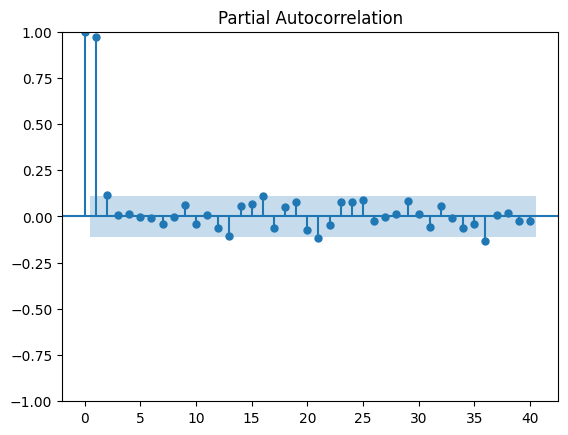

In [ ]:
# plot partial auto-correlation

from statsmodels.graphics.tsaplots import plot_pacf

val = data['Close'].values

# Plot partial autocorrelation
plt.figure(figsize=(10, 10))

plot_pacf(val, lags=40)
plt.show()


In [ ]:
from statsmodels.tsa.stattools import pacf

# Assuming 'df' is your DataFrame and 'Close' is the column with your time series data
val = data['Close'].values

# Calculate partial autocorrelation and confidence intervals
autocorr, confint = pacf(val, nlags=40, alpha=0.05, method='ols')

# Print autocorrelations and confidence intervals
for i in range(len(autocorr)):
    print('Lag: %s' % i)
    print('Partial Autocorrelation: %s' % autocorr[i])
    print('Confidence interval: [%s, %s]' % (confint[i, 0], confint[i, 1]))
    print('---')


Lag: 0
Partial Autocorrelation: 1.0
Confidence interval: [1.0, 1.0]
---
Lag: 1
Partial Autocorrelation: 0.9722651026463273
Confidence interval: [0.8591065292387101, 1.0854236760539444]
---
Lag: 2
Partial Autocorrelation: 0.11884957632113001
Confidence interval: [0.005691002913512835, 0.23200814972874717]
---
Lag: 3
Partial Autocorrelation: 0.013948451202691696
Confidence interval: [-0.09921012220492548, 0.12710702461030887]
---
Lag: 4
Partial Autocorrelation: 0.01332755438510784
Confidence interval: [-0.09983101902250933, 0.126486127792725]
---
Lag: 5
Partial Autocorrelation: 0.006213752004916086
Confidence interval: [-0.10694482140270109, 0.11937232541253326]
---
Lag: 6
Partial Autocorrelation: 0.00699904455030049
Confidence interval: [-0.10615952885731668, 0.12015761795791767]
---
Lag: 7
Partial Autocorrelation: -0.04206755494978572
Confidence interval: [-0.1552261283574029, 0.07109101845783145]
---
Lag: 8
Partial Autocorrelation: 0.006303972984981131
Confidence interval: [-0.1068546

PACF Value at Lag 0 (k = 0):

    The PACF at lag 0 is always 1, as the time series is perfectly correlated with itself at lag 0.

PACF Value at Other Lags (k > 0):

    The PACF at a particular lag (k) represents the correlation between the series values at time t and the values at time t-k after removing the effects of the lags between 1 and k-1.
    If the PACF at a specific lag is significantly different from zero, it suggests a direct relationship between the current value and the value at that lag.
    If the PACF is close to 1 or -1 at a certain lag (e.g., PACF = 0.8 or PACF = -0.8), it indicates a strong positive or negative correlation at that lag.

A significant PACF value is one that falls outside the confidence interval.
If a PACF value is outside the confidence interval, it suggests that there is a significant partial autocorrelation at that lag.

## Making Close Stationary

In [ ]:
# take first order differencing of CLose

data['Close_diff'] = data['Close'].diff()

# data.dropna(inplace=True)
#
# replace null with 0
data.fillna(0, inplace=True)
data.head()


,id,Date,Open,Close,Volume,Strategy,Close_diff
0,0,2015-06-01,66.208486,75.609978,298506300,1,0.000000
1,1,2015-06-08,64.116235,74.443331,227974800,1,-1.166647
2,2,2015-06-15,47.701942,71.140831,250670900,0,-3.302500
3,3,2015-06-22,54.754816,72.881344,223614300,1,1.740512
4,4,2015-06-29,48.031899,66.284718,406814900,0,-6.596626


In [ ]:
# adf fuller test

adfuller_test(data['Close_diff'])



ADF Test Statistic: -19.644552498398333
p-value: 0.0
#Lags Used: 0
#Observation Used: 299
Strong evidence against the null hypothesis, Hence REJECT Ho. and The series is Stationary


Close_diff is stationary

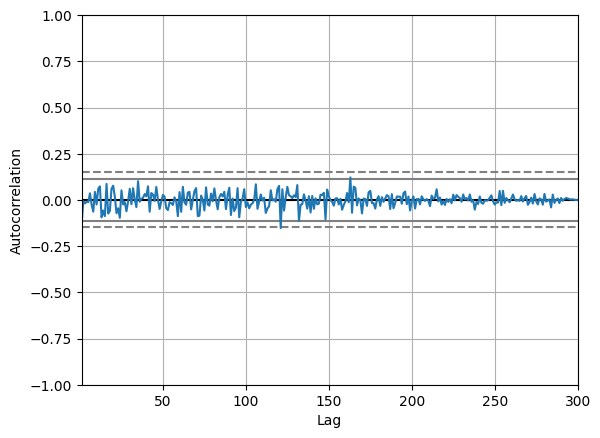

In [ ]:
autocorrelation_plot(data['Close_diff'])
plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf

val = data['Close_diff'].values

# Calculate autocorrelation and confidence intervals
autocorr, confint = acf(val, nlags=40, alpha=0.05, fft=True)

# Print autocorrelations and confidence intervals
for i in range(len(autocorr)):
    print('Lag: %s' % i)
    print('Autocorrelation: %s' % autocorr[i])
    print('Confidence interval: %s' % confint[i])
    print('---')


Lag: 0
Autocorrelation: 1.0
Confidence interval: [1. 1.]
---
Lag: 1
Autocorrelation: -0.13084268822483786
Confidence interval: [-0.24400126 -0.01768411]
---
Lag: 2
Autocorrelation: -0.006651121168546026
Confidence interval: [-0.12173064  0.1084284 ]
---
Lag: 3
Autocorrelation: -0.018816471725204485
Confidence interval: [-0.13390092  0.09626797]
---
Lag: 4
Autocorrelation: -0.009930545307186803
Confidence interval: [-0.12505438  0.10519329]
---
Lag: 5
Autocorrelation: -0.011766075301735412
Confidence interval: [-0.12690088  0.10336872]
---
Lag: 6
Autocorrelation: 0.03592386639124248
Confidence interval: [-0.07922633  0.15107406]
---
Lag: 7
Autocorrelation: -0.025228331848478218
Confidence interval: [-0.14052195  0.09006528]
---
Lag: 8
Autocorrelation: -0.06362997801237032
Confidence interval: [-0.17899426  0.0517343 ]
---
Lag: 9
Autocorrelation: 0.04363306114564066
Confidence interval: [-0.07217974  0.15944586]
---
Lag: 10
Autocorrelation: -0.024652321171204184
Confidence interval: [-0.

<Figure size 1000x1000 with 0 Axes>

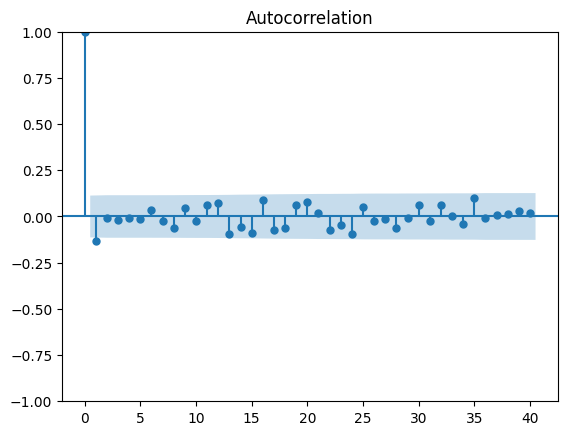

In [ ]:
# plot auto-correlation

plt.figure(figsize=(10, 10))

# Plot autocorrelation
plot_acf(data['Close_diff'], lags=40)

plt.show()

In [ ]:
from statsmodels.tsa.stattools import pacf

# Assuming 'df' is your DataFrame and 'Close' is the column with your time series data
val = data['Close_diff'].values

# Calculate partial autocorrelation and confidence intervals
autocorr, confint = pacf(val, nlags=40, alpha=0.05, method='ols')

# Print autocorrelations and confidence intervals
for i in range(len(autocorr)):
    print('Lag: %s' % i)
    print('Partial Autocorrelation: %s' % autocorr[i])
    print('Confidence interval: [%s, %s]' % (confint[i, 0], confint[i, 1]))
    print('---')


Lag: 0
Partial Autocorrelation: 1.0
Confidence interval: [1.0, 1.0]
---
Lag: 1
Partial Autocorrelation: -0.13107400176961367
Confidence interval: [-0.24423257517723085, -0.0179154283619965]
---
Lag: 2
Partial Autocorrelation: -0.024543280105564634
Confidence interval: [-0.13770185351318182, 0.08861529330205253]
---
Lag: 3
Partial Autocorrelation: -0.023833530717695284
Confidence interval: [-0.13699210412531246, 0.08932504268992189]
---
Lag: 4
Partial Autocorrelation: -0.016027800207692247
Confidence interval: [-0.12918637361530944, 0.09713077319992493]
---
Lag: 5
Partial Autocorrelation: -0.016632533150356208
Confidence interval: [-0.12979110655797338, 0.09652604025726097]
---
Lag: 6
Partial Autocorrelation: 0.031160387150399607
Confidence interval: [-0.08199818625721757, 0.1443189605580168]
---
Lag: 7
Partial Autocorrelation: -0.017051421722646905
Confidence interval: [-0.13020999513026407, 0.09610715168497028]
---
Lag: 8
Partial Autocorrelation: -0.07195565620637538
Confidence interv

<Figure size 1000x1000 with 0 Axes>

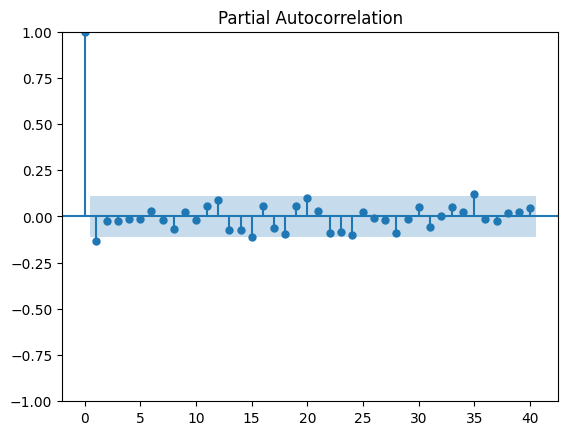

In [ ]:
# plot auto-correlation

plt.figure(figsize=(10, 10))

# Plot autocorrelation
plot_pacf(data['Close_diff'], lags=40)

plt.show()

# Seasonality Check

<AxesSubplot:>

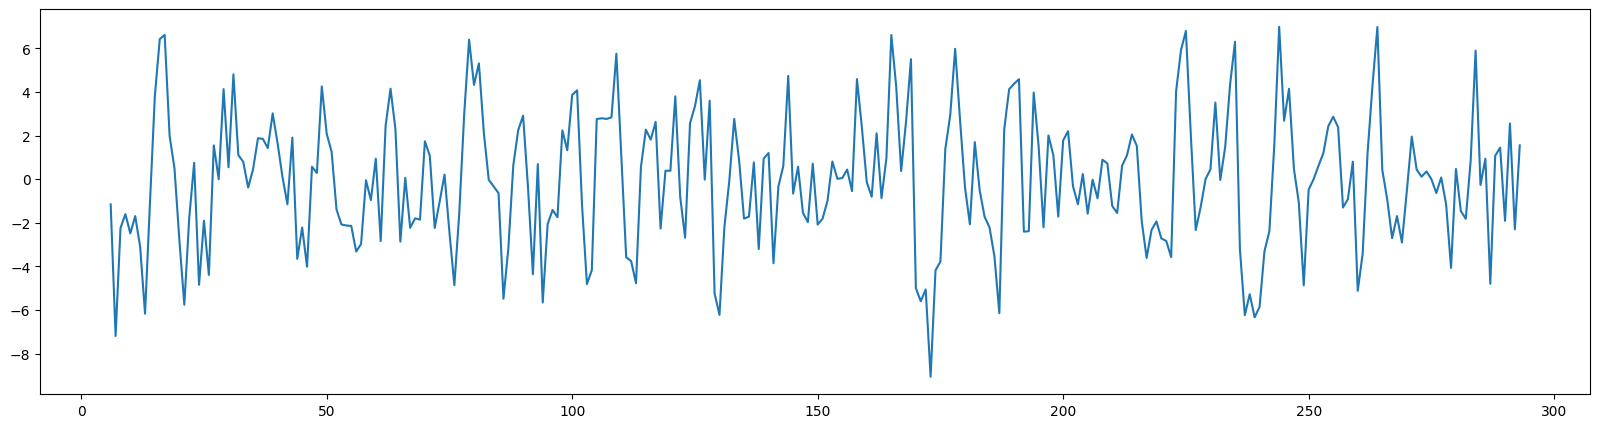

In [ ]:
s = sm.tsa.seasonal_decompose(train.Close,period=12)

s.resid.plot(figsize=(20,5))

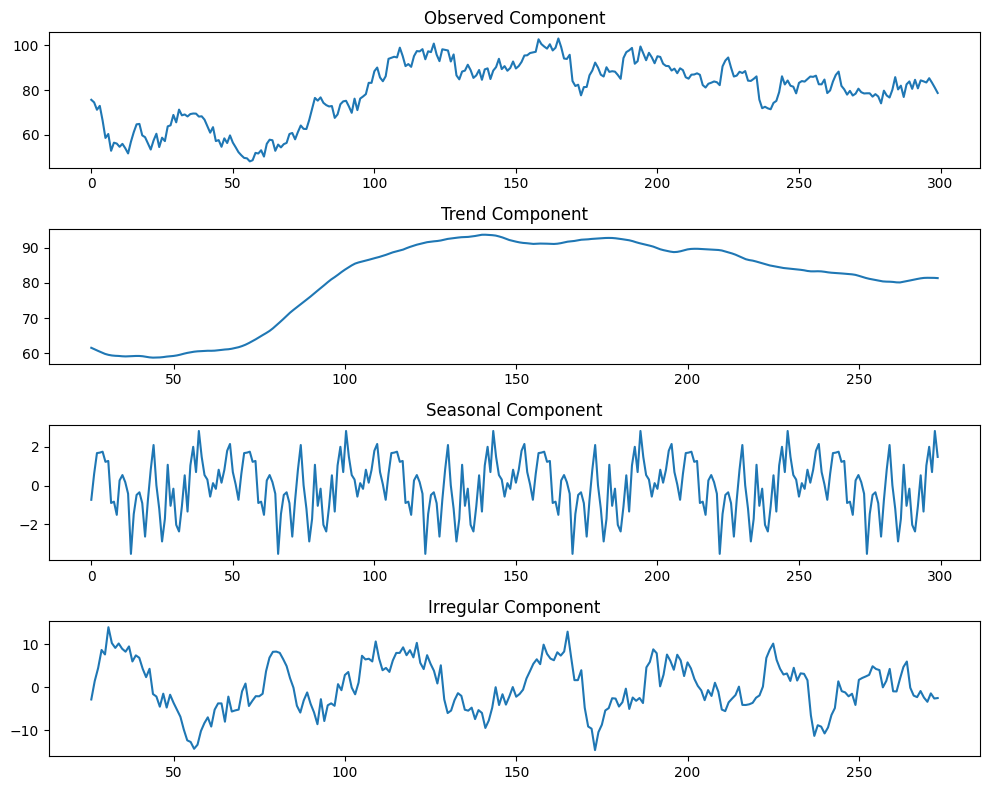

In [ ]:
result = seasonal_decompose(data['Close'].values, model='additive', period=52)

# Plot the components
plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plt.plot(result.observed)
plt.title("Observed Component")

plt.subplot(4, 1, 2)
plt.plot(result.trend)
plt.title("Trend Component")

plt.subplot(4, 1, 3)
plt.plot(result.seasonal)
plt.title("Seasonal Component")

plt.subplot(4, 1, 4)
plt.plot(result.resid)
plt.title("Irregular Component")

plt.tight_layout()
plt.show()


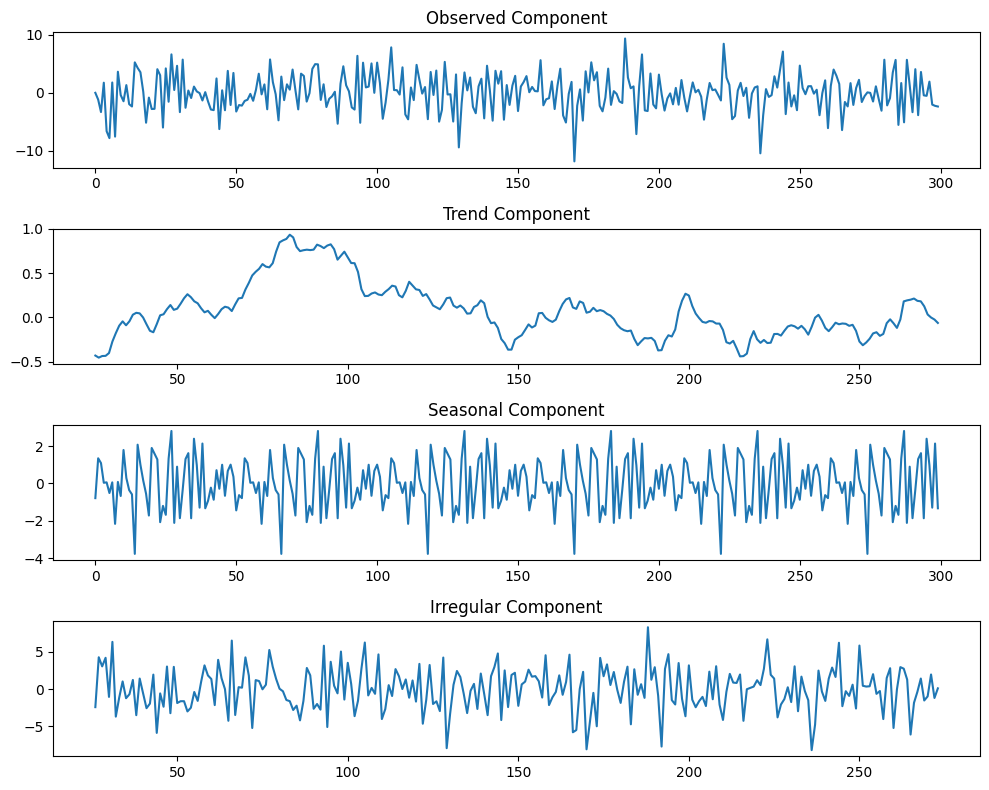

In [ ]:
result = seasonal_decompose(data['Close_diff'].values, model='additive', period=52)

# Plot the components
plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plt.plot(result.observed)
plt.title("Observed Component")

plt.subplot(4, 1, 2)
plt.plot(result.trend)
plt.title("Trend Component")

plt.subplot(4, 1, 3)
plt.plot(result.seasonal)
plt.title("Seasonal Component")

plt.subplot(4, 1, 4)
plt.plot(result.resid)
plt.title("Irregular Component")

plt.tight_layout()
plt.show()


Data is seasonal

# Helper Functions

In [ ]:
strategy_mapping = {'Buy': 0, 'Hold': 1, 'Sell': 2}

def smape(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

def temporal_metrics(y_pred,y_true):
    print("Mean Absolute Error: ",mean_absolute_error(y_true,y_pred))
    print("Mean Squared Error: ",mean_squared_error(y_true,y_pred))
    print("Root Mean Squared Error: ",np.sqrt(mean_squared_error(y_true,y_pred)))
    print("Smape: ", smape(y_true,y_pred))


def classification_metrics(y_pred,y_true):
    print("Accuracy: ",accuracy_score(y_true,y_pred))
    print("Precision: ",precision_score(y_true,y_pred, average='macro'))
    print("Recall: ",recall_score(y_true,y_pred, average='macro'))
    print("F1 Score: ",f1_score(y_true,y_pred, average='macro'))
    print("Confusion Matrix: \n",confusion_matrix(y_true,y_pred))


def train_validation_split(X,Y):
    train_size = int(0.8 * len(data))

    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = Y[:train_size], Y[train_size:]
    return X_train,y_train,X_test,y_test

def print_shape(X_train,y_train,X_test,y_test):
    print("X train shape :", X_train.shape )
    print("X test shape :", X_test.shape )
    print("y train shape :", y_train.shape )
    print("y test shape :", y_test.shape )

def calculate_rsi_class(data, window=14):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi



# Calculate RSI
def calculate_rsi( df, window=14):
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi



# Feature Engineering

- Open_MA
- Volume_MA
- MACD
- MACD_Signal
- Market Participation
- Open_diff
- Volume_diff
- log_Volume
- RSI
- SMA (on close data for Str)

In [ ]:
def feature_engineering_for_close(df):
    # convert Date to datetime
    df['Date'] = pd.to_datetime(df['Date'])

    df['Open_MA'] = df['Open'].rolling(window=5).mean()
    df['Volume_MA'] = df['Volume'].rolling(window=5).mean()

    short_window = 14  # Adjust the short-term window
    long_window = 21  # Adjust the long-term window
    ema_short = df['Open'].ewm(span=short_window, adjust=True).mean()
    ema_long = df['Open'].ewm(span=long_window, adjust=True).mean()

    df['MACD'] = ema_short - ema_long


    # Signal line for MACD
    signal_window = 9  # Adjust the signal window
    df['MACD_Signal'] = df['MACD'].ewm(span=signal_window, adjust=True).mean()
    df['Market Participation'] = df["Volume"] / (df['Open'])**4

    df['Open_diff']= df["Open"].diff()
    df['Volume_diff'] = df["Volume"].diff()
    df['log_Volume']= np.log(df['Volume'])

    # Set null values to 0
    df.fillna(0, inplace=True)
    return df

def feature_engineering_for_strategy(df):
    df= feature_engineering_for_close(df)
    df['SMA'] = df['Close'].rolling(window=10).mean()
    # df['Strategy'] = df['Strategy'].astype('category')
    # df['Strategy'] = df['Strategy'].map({"Hold":1,"Buy":0,"Sell":2})
    df['RSI'] = calculate_rsi( df)

    df['Open_RSI'] = calculate_rsi_class(df['Open'])
    df['Volume_MA_5'] = df['Volume'].rolling(window=5).mean()
    df['Volume_MA_10'] = df['Volume'].rolling(window=10).mean()
    # Feature: Daily price change
    df['Price_Change'] = df['Close'].diff(1)

    # Feature: Daily volume change
    df['Volume_Change'] = df['Volume'].diff(1)
    rsi_volume_period = 14  # Adjust the RSI volume period
    df['Volume_RSI'] = calculate_rsi_class(df['Volume'], window=rsi_volume_period)
    # Feature: Previous day's Close price
    df['Previous_Close'] = df['Close'].shift(1)

    # Feature: Percentage change in Close price
    df['Close_Percentage_Change'] = df['Close'].pct_change()
    window = 20  # Adjust the window size
    df['RollingMean'] = df['Close'].rolling(window=window).mean()
    df['UpperBand'] = df['RollingMean'] + 2 * df['Close'].rolling(window=window).std()
    df['LowerBand'] = df['RollingMean'] - 2 * df['Close'].rolling(window=window).std()

    return df

def select_features(df,features):
    return df[features]

def map_strategy(df):
    df['Strategy'] = df['Strategy'].astype('category')
    df['Strategy'] = df['Strategy'].map({"Hold":1,"Buy":0,"Sell":2})
    return df




In [ ]:
data = feature_engineering_for_close(data)
data.head()

,id,Date,Open,Close,Volume,Strategy,Close_diff,Open_MA,Volume_MA,MACD,MACD_Signal,Market Participation,Open_diff,Volume_diff,log_Volume
0,0,2015-06-01,66.208486,75.609978,298506300,1,0.000000,0.000000,0.0,0.000000,0.000000,15.534557,0.000000,0.0,19.514302
1,1,2015-06-08,64.116235,74.443331,227974800,1,-1.166647,0.000000,0.0,-0.024908,-0.013838,13.490088,-2.092251,-70531500.0,19.244746
2,2,2015-06-15,47.701942,71.140831,250670900,0,-3.302500,0.000000,0.0,-0.301701,-0.131815,48.412743,-16.414294,22696100.0,19.339651
3,3,2015-06-22,54.754816,72.881344,223614300,1,1.740512,0.000000,0.0,-0.285817,-0.183983,24.877702,7.052875,-27056600.0,19.225433
4,4,2015-06-29,48.031899,66.284718,406814900,0,-6.596626,56.162676,281516240.0,-0.413026,-0.252118,76.432454,-6.722917,183200600.0,19.823869


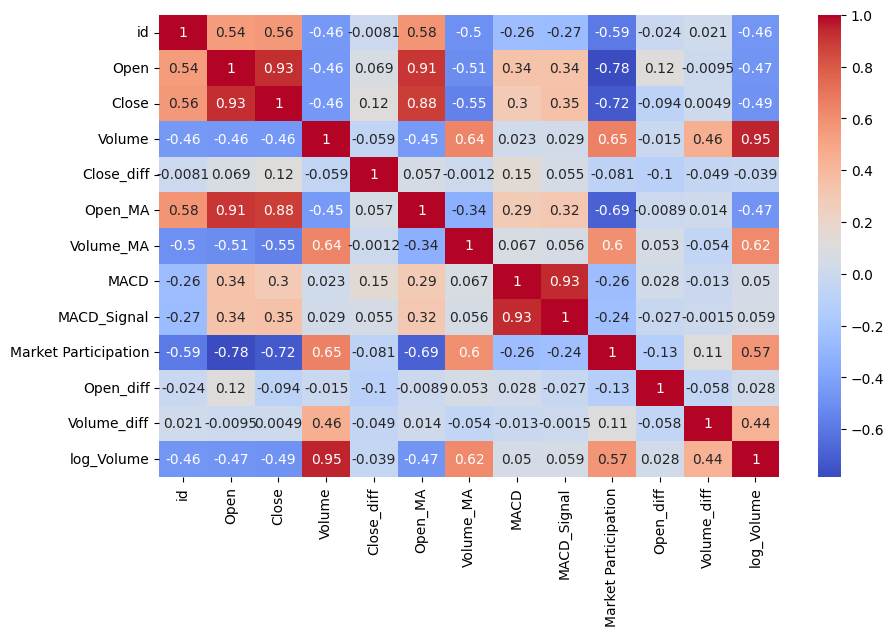

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(),annot=True, cmap='coolwarm')
plt.show()

In [ ]:
data.columns

Index(['id', 'Date', 'Open', 'Close', 'Volume', 'Strategy', 'Close_diff',
       'Open_MA', 'Volume_MA', 'MACD', 'MACD_Signal', 'Market Participation',
       'Open_diff', 'Volume_diff', 'log_Volume'],
      dtype='object')

In [ ]:
data2= train.copy()
data2.head()

,id,Date,Open,Close,Volume,Strategy
0,0,2015-06-01,66.208486,75.609978,298506300,Hold
1,1,2015-06-08,64.116235,74.443331,227974800,Hold
2,2,2015-06-15,47.701942,71.140831,250670900,Buy
3,3,2015-06-22,54.754816,72.881344,223614300,Hold
4,4,2015-06-29,48.031899,66.284718,406814900,Buy


In [ ]:
data2 = feature_engineering_for_strategy(data2)
data2.head()

,id,Date,Open,Close,Volume,Strategy,Open_MA,Volume_MA,MACD,MACD_Signal,...,Volume_MA_5,Volume_MA_10,Price_Change,Volume_Change,Volume_RSI,Previous_Close,Close_Percentage_Change,RollingMean,UpperBand,LowerBand
0,0,2015-06-01,66.208486,75.609978,298506300,Hold,0.000000,0.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2015-06-08,64.116235,74.443331,227974800,Hold,0.000000,0.0,-0.024908,-0.013838,...,NaN,NaN,-1.166647,-70531500.0,NaN,75.609978,-0.015430,NaN,NaN,NaN
2,2,2015-06-15,47.701942,71.140831,250670900,Buy,0.000000,0.0,-0.301701,-0.131815,...,NaN,NaN,-3.302500,22696100.0,NaN,74.443331,-0.044363,NaN,NaN,NaN
3,3,2015-06-22,54.754816,72.881344,223614300,Hold,0.000000,0.0,-0.285817,-0.183983,...,NaN,NaN,1.740512,-27056600.0,NaN,71.140831,0.024466,NaN,NaN,NaN
4,4,2015-06-29,48.031899,66.284718,406814900,Buy,56.162676,281516240.0,-0.413026,-0.252118,...,281516240.0,NaN,-6.596626,183200600.0,NaN,72.881344,-0.090512,NaN,NaN,NaN


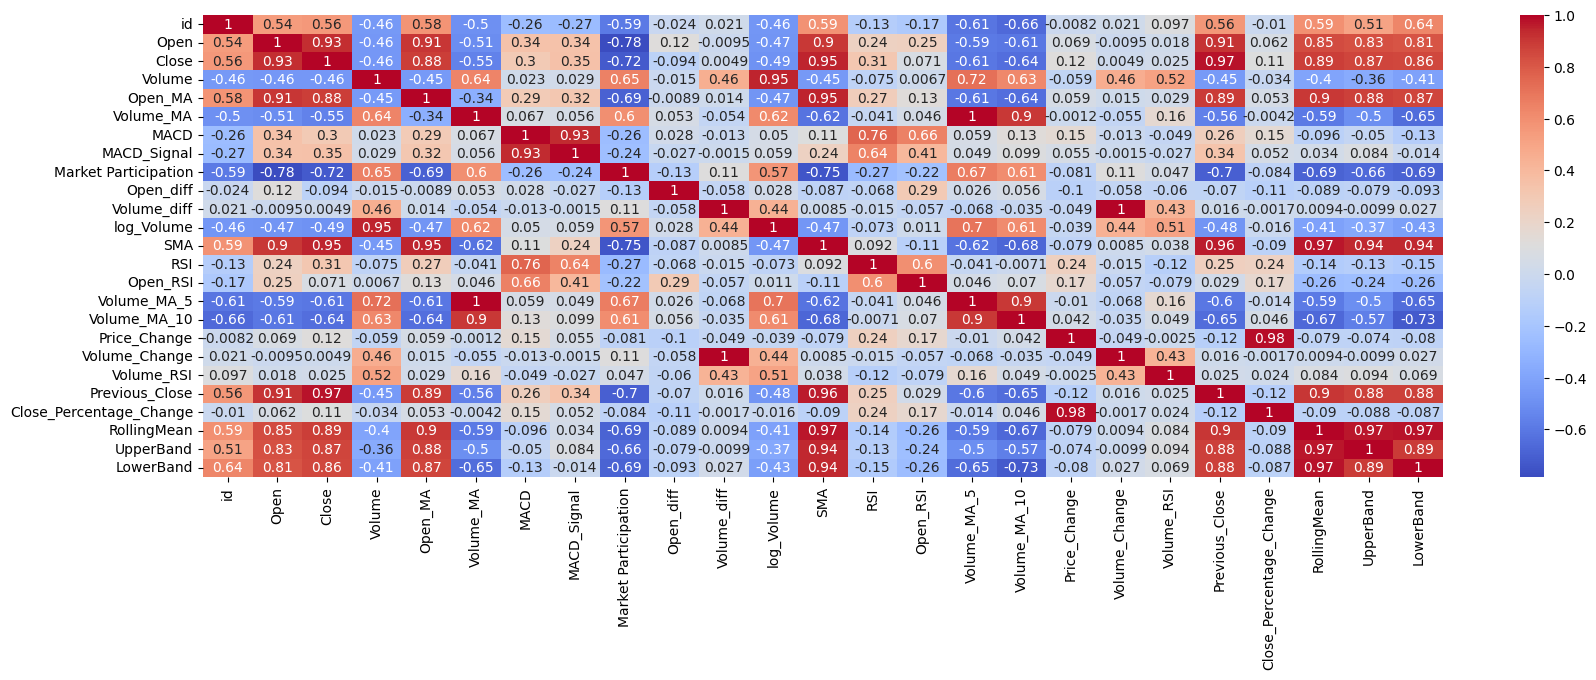

In [ ]:
plt.figure(figsize=(20,6))
sns.heatmap(data2.corr(),annot=True, cmap='coolwarm')
plt.show()

In [ ]:
data2.columns

Index(['id', 'Date', 'Open', 'Close', 'Volume', 'Strategy', 'Open_MA',
       'Volume_MA', 'MACD', 'MACD_Signal', 'Market Participation', 'Open_diff',
       'Volume_diff', 'log_Volume', 'SMA', 'RSI', 'Open_RSI', 'Volume_MA_5',
       'Volume_MA_10', 'Price_Change', 'Volume_Change', 'Volume_RSI',
       'Previous_Close', 'Close_Percentage_Change', 'RollingMean', 'UpperBand',
       'LowerBand'],
      dtype='object')

# Close Value Model Training

In [ ]:
def plot_predicted_actual(test,pred):
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test, label='Actual Close')
    plt.plot(test.index, pred, label='Predicted Close')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

def plot_predicted(train,pred):
    plt.figure(figsize=(10, 6))
    plt.plot( train, label='Actual Close')
    plt.plot( pred, label='Predicted Close')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

In [ ]:
feature=['Open', 'Open_MA', 'MACD_Signal', 'MACD', 'id']

X = select_features(data,feature)
Y = data['Close']

In [ ]:
X.head()

,Open,Open_MA,MACD_Signal,MACD,id
0,66.208486,0.000000,0.000000,0.000000,0
1,64.116235,0.000000,-0.013838,-0.024908,1
2,47.701942,0.000000,-0.131815,-0.301701,2
3,54.754816,0.000000,-0.183983,-0.285817,3
4,48.031899,56.162676,-0.252118,-0.413026,4


In [ ]:
X_train,y_train,X_val,y_val = train_validation_split(X,Y)

In [ ]:
print_shape(X_train,y_train,X_val,y_val)

X train shape : (240, 5)
X test shape : (60, 5)
y train shape : (240,)
y test shape : (60,)


In [ ]:
endog= y_train
exog= sm.add_constant(X_train)

In [ ]:
mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog,order=(7,0,3),seasonal_order=(7,0,3,12))
model_fit = mod.fit(exog=exog)


In [ ]:
# Make predictions for the training set
res = model_fit.predict(exog=exog)
temporal_metrics(y_train,res)

Mean Absolute Error:  2.4996011316599267
Mean Squared Error:  22.698670098243312
Root Mean Squared Error:  4.764312132747319
Smape:  0.017415602872842613


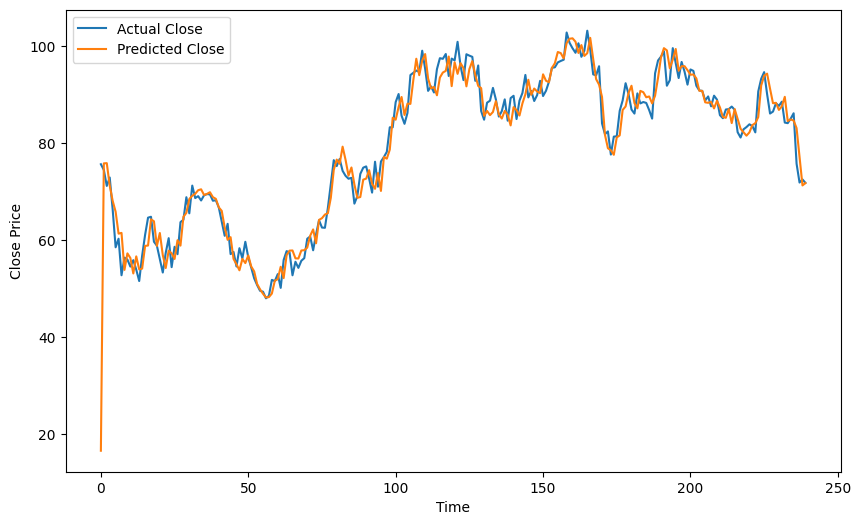

In [ ]:
plot_predicted_actual(y_train,res)

In [ ]:
# for test data
exog= sm.add_constant(X_val)

# Make predictions for the test set
res = model_fit.forecast(steps=len(X_val),exog=exog)


In [ ]:
temporal_metrics(y_val,res)

Mean Absolute Error:  5.1287463818988615
Mean Squared Error:  35.87029070107162
Root Mean Squared Error:  5.989181137774313
Smape:  0.03103185980868079


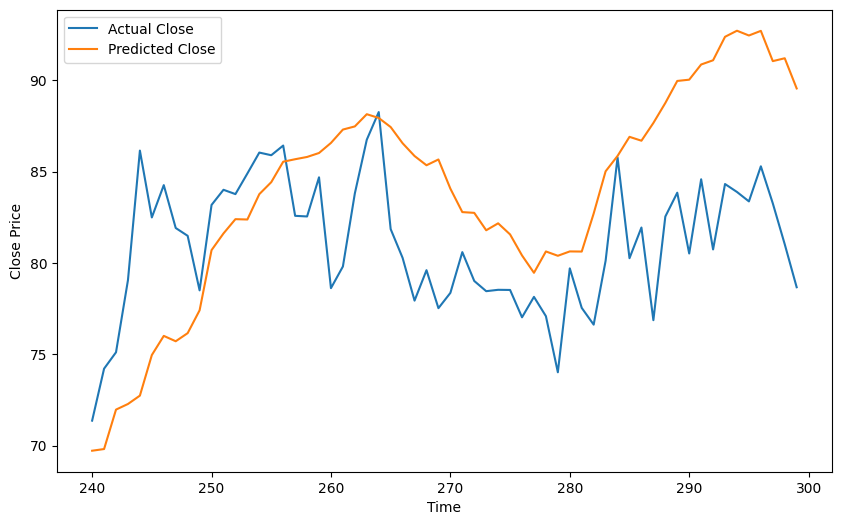

In [ ]:
plot_predicted_actual(y_val,res)


In [ ]:
test_data= test.copy()
test_data= feature_engineering_for_close(test_data)
test_data.head()

,id,Date,Open,Volume,Open_MA,Volume_MA,MACD,MACD_Signal,Market Participation,Open_diff,Volume_diff,log_Volume
0,0,2021-03-01,72.708331,205897600,0.000000,0.0,0.000000,0.000000,7.367406,0.000000,0.0,19.142890
1,1,2021-03-08,73.310886,214095600,0.000000,0.0,0.007173,0.003985,7.411974,0.602555,8198000.0,19.181933
2,2,2021-03-15,70.610119,151601700,0.000000,0.0,-0.035261,-0.012099,6.098686,-2.700767,-62493900.0,18.836767
3,3,2021-03-22,70.256017,193982500,0.000000,0.0,-0.060557,-0.028514,7.962115,-0.354102,42380800.0,19.083279
4,4,2021-03-29,68.258324,220238400,71.028735,197163160.0,-0.115225,-0.054309,10.145432,-1.997693,26255900.0,19.210221


In [ ]:
exog_test = select_features(test_data,feature)
exog_test = sm.add_constant(exog_test)
exog_test.shape


(100, 6)

In [ ]:
exog_X_val = sm.add_constant(X_val[feature])
exog_X_val.shape
# # Add the corresponding data points
final_exog =  pd.concat([exog_X_val,exog_test], ignore_index=True)

# final_exog.head()
final_exog.shape

(160, 6)

In [ ]:
predicted_close = model_fit.forecast(steps=final_exog.shape[0], exog=final_exog)
predicted_close

240    69.719347
241    69.811183
242    71.970890
243    72.278797
244    72.736427
         ...    
395    49.861795
396    50.954595
397    51.885636
398    53.913351
399    54.543193
Name: predicted_mean, Length: 160, dtype: float64

In [ ]:
test_pred=predicted_close[-100:]
test_pred

300    60.114541
301    59.566964
302    60.609353
303    60.382515
304    53.862586
         ...    
395    49.861795
396    50.954595
397    51.885636
398    53.913351
399    54.543193
Name: predicted_mean, Length: 100, dtype: float64

# Train full model

In [ ]:
df = train.copy()

# Feature engineering
df['Open_MA'] = df['Open'].rolling(window=5).mean()
short_window = 14  # Adjust the short-term window
long_window = 21  # Adjust the long-term window
df['Volume_MA'] = df['Volume'].rolling(window=5).mean()
ema_short = df['Open'].ewm(span=short_window, adjust=True).mean()
ema_long = df['Open'].ewm(span=long_window, adjust=True).mean()

df['MACD'] = ema_short - ema_long

# Signal line for MACD
signal_window = 9  # Adjust the signal window
df['MACD_Signal'] = df['MACD'].ewm(span=signal_window, adjust=True).mean()
df['Market Participation'] = df["Volume"] / (df['Open'])**4

# Set null values to 0
df.fillna(0, inplace=True)

tr=df
endog = tr['Close']
exog = sm.add_constant(tr[['Open', 'Open_MA', 'MACD_Signal', 'MACD', 'id']])

# Fit the SARIMA model
mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog,order=(7,0,3),seasonal_order=(7,0,3,12))
model_fit = mod.fit(exog=exog)

# Make predictions for the tring set
res = model_fit.predict(exog=exog)

print("Predicted Values:")
print(res)
print("Actual Values (Close):")
print(tr['Close'])

smape_value = smape(res, tr['Close'])
accuracy_percentage = (1 - smape_value) * 100

print("Symmetric Mean Absolute Percentage Error (SMAPE): {:.2f}".format(smape_value ))
print("Accuracy Percentage: {:.2f}%".format(accuracy_percentage))

test_exog_data = pd.read_csv('test.csv')
test_exog_data['Open_MA'] = test_exog_data['Open'].rolling(window=5).mean()

short_window = 14  # Adjust the short-term window
long_window = 21  # Adjust the long-term window
ema_short = test_exog_data['Open'].ewm(span=short_window, adjust=True).mean()
ema_long = test_exog_data['Open'].ewm(span=long_window, adjust=True).mean()

test_exog_data['MACD'] = ema_short - ema_long
test_exog_data['MACD_Signal'] = test_exog_data['MACD'].ewm(span=signal_window, adjust=True).mean()
test_exog = sm.add_constant(test_exog_data[['Open', 'Open_MA', 'MACD_Signal', 'MACD', 'id']])
# test_exog_data.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
test_exog.fillna(0, inplace=True)
# # Use the 'forecast' method to predict 'Close' based on exogenous variables in the test data

predicted_close = model_fit.forecast(steps=len(test_exog), exog=test_exog)
predicted_close.index = test_exog_data['Date']





Predicted Values:
0      56.447914
1      67.673862
2      59.229896
3      64.521979
4      72.076520
         ...    
295    84.341950
296    79.202578
297    83.590365
298    83.375751
299    79.102620
Name: predicted_mean, Length: 300, dtype: float64
Actual Values (Close):
0      75.609978
1      74.443331
2      71.140831
3      72.881344
4      66.284718
         ...    
295    83.373498
296    85.294903
297    83.266453
298    81.026827
299    78.672007
Name: Close, Length: 300, dtype: float64
Symmetric Mean Absolute Percentage Error (SMAPE): 0.02
Accuracy Percentage: 98.29%


In [ ]:

# Create a DataFrame with the predicted values
submission_df = pd.DataFrame({'Close': predicted_close})

print(submission_df)

combined_df = submission_df.merge(test_exog_data, on='Date', how='inner')

# Rename the 'Open' and 'Volume' columns to avoid conflicts
combined_df = combined_df.rename(columns={'Open_y': 'Open', 'Volume_y': 'Volume'})

print(combined_df)


                Close
Date                 
2021-03-01  57.984819
2021-03-08  58.787931
2021-03-15  56.617398
2021-03-22  58.856155
2021-03-29  70.086632
...               ...
2022-12-26  61.403988
2023-01-02  62.888298
2023-01-09  63.522994
2023-01-16  61.208744
2023-01-23  62.097077

[100 rows x 1 columns]
          Date      Close  id       Open     Volume    Open_MA      MACD  \
0   2021-03-01  57.984819   0  72.708331  205897600        NaN  0.000000   
1   2021-03-08  58.787931   1  73.310886  214095600        NaN  0.007173   
2   2021-03-15  56.617398   2  70.610119  151601700        NaN -0.035261   
3   2021-03-22  58.856155   3  70.256017  193982500        NaN -0.060557   
4   2021-03-29  70.086632   4  68.258324  220238400  71.028735 -0.115225   
..         ...        ...  ..        ...        ...        ...       ...   
95  2022-12-26  61.403988  95  57.048622  224994700  57.609131 -1.324013   
96  2023-01-02  62.888298  96  60.569661  176020500  58.129659 -1.087069   
97  20

# Predicting Strategy

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer



In [ ]:



# Calculate the SMA values
df['SMA'] = df['Close'].rolling(window=10).mean()

# Calculate RSI
def calculate_rsi( df, window=14):
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = calculate_rsi( df)
# Feature: Daily price change


# Define the features and target variable
features = ['Open','Close', 'SMA','Open_MA','MACD','MACD_Signal']
X =  df[features]

# Use LabelEncoder to encode class labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform( df['Strategy'])

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Split the data into a training set and a validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Create and train the KNN classifier with hyperparameter tuning
param_grid = {'n_neighbors': [5]}
knn_classifier = KNeighborsClassifier()
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)
best_knn_classifier = grid_search.best_estimator_

# Make predictions on the validation set
y_valid_pred = best_knn_classifier.predict(X_valid_scaled)

y_train_pred = best_knn_classifier.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Train Accuracy with KNN: {train_accuracy}")



# Calculate the validation accuracy
validation_accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Validation Accuracy with KNN: {validation_accuracy}")


Train Accuracy with KNN: 0.825
Validation Accuracy with KNN: 0.85


In [ ]:
test_data = combined_df

# Calculate the SMA values for the test data
test_data['SMA'] = test_data['Close'].rolling(window=10).mean()

# Calculate RSI for the test data
test_data['RSI'] = calculate_rsi(test_data)
# Define the features for the test data
X_test = test_data[features]

# Impute missing values in the test data
X_test = imputer.transform(X_test)

# Standardize features for the test data
X_test_scaled = scaler.transform(X_test)

y_test_pred = best_knn_classifier.predict(X_test_scaled)

y_test_pred_original = label_encoder.inverse_transform(y_test_pred)



In [ ]:
test_predictions = pd.DataFrame({
    'Date': test_data['Date'],
    'Close': test_data['Close'],
    'Strategy': y_test_pred_original
})

In [ ]:
test_predictions.head()

,Date,Close,Strategy
0,2021-03-01,57.984819,Buy
1,2021-03-08,58.787931,Buy
2,2021-03-15,56.617398,Buy
3,2021-03-22,58.856155,Buy
4,2021-03-29,70.086632,Buy


In [ ]:
submission = pd.DataFrame()
submission["Date"] = test["Date"]

In [ ]:
submission["Close"] = test_predictions["Close"]
submission["Strategy"] = test_predictions["Strategy"]

In the cell above, we have just provided an example of how to create your submission DataFrame. Please make sure to use your own forecasts and predictions, in place of sample_submission["Close"] and sample_submission["Strategy"]

In [ ]:
submission.head()

,Date,Close,Strategy
0,2021-03-01,57.984819,Buy
1,2021-03-08,58.787931,Buy
2,2021-03-15,56.617398,Buy
3,2021-03-22,58.856155,Buy
4,2021-03-29,70.086632,Buy


In [ ]:
submission.to_csv('submission.csv', index=True,index_label='id')